In [7]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import sys
sys.path.append('../python/')
import gis_functions as gf
import lem
import pandas as pd
from gis_functions import generate_pour_point_catchment
from shapely.geometry import shape
from rasterio.features import shapes
import geopandas as gpd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
pts = gpd.read_file('/Users/gr_1/Downloads/crn_int_outlets_4326')
bain = gpd.read_file('/Users/gr_1/Downloads/crn_int_4326')


In [9]:
pts = pts.set_index('OBSID1')
pts = pts.reindex(bain['OBSID1'])
pts.index = np.arange(len(pts))
Areas = bain.geometry.area

/var/folders/5v/804c95h92bx2zr8rfpwyr_yc0000gn/T/ipykernel_1219/2235362367.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Areas = bain.geometry.area


In [ ]:
num=106
for num in range(1858,5000):
    pt = [pts.loc[num].geometry.xy[1][0], pts.loc[num].geometry.xy[0][0]]
    filenm = f'/Volumes/LaCie/alldems/glob_bas_hydroshed_{str(num)}_.tif'
    outnm = f'/Volumes/LaCie/dems_clipped/glob_bas_hydroshed_{str(num)}_.tif'
    try:
        f = rio.open(filenm) #File containing DEM
    except:
        print('no file: ' + str(num))
        continue
    #fig,ax = plt.subplots(1,1)

    Z=np.float64(np.squeeze(f.read()))
    m,n = np.shape(Z)
    lat = np.array([f.xy(i,0)[1] for i in range(m)])
    lon = np.array([f.xy(0,i)[0] for i in range(n)])

    #plt.pcolormesh(lon, lat, Z, cmap='terrain')
    dem=lem.simple_model()

    Z[np.isnan(Z)] = -9999
    dem.set_z(Z)
    dem.dy = np.mean(np.diff(lon)) * 111000
    dem.dx =  np.cos(np.abs(np.mean(lat))/180*np.pi) * (1852/60)
    dem.sinkfill()
    Z=dem.get_z().copy()
    Z[Z<=0] = np.nan
    dem.set_z(Z)
    dem.slp()
    dem.stack()
    dem.acc()
    A = dem.A
    athres = 100 #threshold drainage area for plotting
    IJ = np.where((A>athres) & (Z>=1))
    #plt.plot(lon[IJ[1]],lat[IJ[0]],'.k',markersize=.1)
    #plt.plot(pt[1],pt[0],'.r',markersize=3)
    Area1 = Areas[num] * 3600**2 * dem.dx*dem.dy
    try:
        df,_ = generate_pour_point_catchment(filenm, outnm, pt, fillsink=True, target_area=Area1, search_area=.1, flowdir=None)
    except Exception as e:
        print(e)
    #df.to_file(f'../dfs/bound_{num}')
    #df.plot(ax=ax,color='red')


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.550447803640989
Filling DEM
34.1965629344803
34.19630266787044
0
1557590.669040842
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=12.549780116871235
Filling DEM
-18.621064402041515
-19.191652645693665
0
21813486574.895927
here
-2627.889980807791
here
-61192.295267381414
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
here
-9911846147.408182
he

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.315910010147107
Filling DEM
35.78339387841995
35.781739312812995
0
23232.14751402631
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.648622170457035
Filling DEM
47.03260837865566
46.73588571889485
0
656935011.4856833
here
-11529.77654328828
here
-39910.76495753636
here
-44345.29439726262
here
-978588897.2057049
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-978612843.6646794
here
-

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.662365197515348
Filling DEM
41.90924953361561
41.61009870770886
0
698482037.4144922
here
-4583.838345301978
here
-4583.838345301978
here
-4583.838345301978
here
-11957.839161657334
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6932843836
here
-647317.6

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.339859443742018
Filling DEM
44.38429530371575
43.99270033577907
0
645230513.2096052
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-909894107.6360941
here
-90989410

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=26.50910735700301
Filling DEM
-29.131996820996477
-29.166186234443185
0
961091373.1574832
here
-11101.870626398535
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
here
-1004334691.1709386
her

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=8.560658442141353
Filling DEM
5.087466562270421
5.051002263783039
0
1241386770.8949785
here
-3585.1574035114545
here
-5121.653433587791
here
-5121.653433587791
here
-102689.15134343522
here
-104225.64737351156
here
-104225.64737351156
here
-104225.64737351156
here
-104225.64737351156
here
-104225.64737351156
here
-751858.7240506879
here
-754419.5507674818
here
-754419.5507674818
here
-754419.5507674818
here
-754419.5507674818
here
-754419.5507674818
here
-754419.5507674818
here
-754419.5507674818
here
-754419.5507674818
here
-754419.5507674818
here
-754419.5507674818
here
-8524736.0575352
here
-8524736.0575352
here
-8552392.986076575
here
-8552392.986076575
here
-8552392.986076575
here
-8552392.986076575
here
-8552392.986076575
here
-8552392.986076575
here
-8552392.986076575
here
-8552392.986076575
here
-8552392.986076575
here
-8552392.986076575
here
-8552392.986076575
here
-85523

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=12.030143009048922
Filling DEM
-18.63936051347488
-19.100563475883945
0
1119765347.2691076
here
-9356.580543992182
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-490973968.6491037
here
-4909

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=8.338205273846066
Filling DEM
4.208313900939543
3.9962004571698975
0
982792495.7178384
here
-282382937.2657317
here
-282382937.2657317
here
-282382937.2657317
here
-282382937.2657317
here
-282382937.2657317
here
-282382937.2657317
here
-282382937.2657317
here
-282382937.2657317
here
-282382937.2657317
here
-282382937.2657317
here
-282382937.2657317
here
-282382937.2657317
here
-282382937.2657317
here
-282382937.2657317
here
-282382937.2657317
here
-282382937.2657317


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=13.268333170181696
Filling DEM
-19.396058184181374
-19.754626834251372
0
874280062.2084152
here
-14685.580379935403
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251
here
-423677406.3308251


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=10.707645087558637
Filling DEM
-32.34400005737147
-32.363200499096145
0
1468086.068763803
here
-623318.2262065641
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.544045016054111
Filling DEM
34.43132999999998
34.4304934624404
0
58406264.35835784
here
35436377.6327576
here
35436377.6327576
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.800159644910309
Filling DEM


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


39.021800000000006
38.989802855460624
0
27089123.76806915
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
here
-6504738.589571279
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.535080416705828
Filling DEM
-21.952626074196065
-22.208914021994314
0
558376795.1338432
here
-3071.4216037252554
here
-425945976.57325995
here
-425945976.57325995
here
-425945976.57325995
here
-425945976.57325995
here
-425945976.573

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.605963527854247
Filling DEM
34.393989412314475
34.373360610370405
0
1297962.7490110837
here
172978.15275270652
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-8.874893367763642
Filling DEM
35.824438473858166
35.814348157626526
0
291518361.1310862
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
108584002.26524377
here
1

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.028069307531425
Filling DEM
34.32154339752818
34.32107866083465
0
2224635.5519321673
here
1128816.12681302
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=22.006521513035533
Filling DEM
-20.866107781442437
-20.888660048923853
0
2506225.713602597
here
-1968319.5744738444
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.272707684276813
Filling DEM
44.11845932225157
43.929369108248636
0
181431401.35069963
here
-3502.6432799504382
here
-254445142.76789963
here
-254445142.76789963
here
-254445142.76789963
here
-254445142.76789963
here
-254445142.76789963
here
-254445142.76789963
here
-254445142.76789963
here
-254445142.76789963
here
-254445142.76789963
here
-254445142.76789963
here
-254445142.76789963
here
-254445142.76789963
here
-254445142.76789963
here
-2544451

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.765208965875221
Filling DEM
36.46781073837807
36.46706404306777
0
86803058.48627701
here
-570.1839181363915
here
-17700361.916687537


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.765208965875221
Filling DEM
36.46781073837807
36.46706404306777
0
86803058.48627701
here
-570.1839181363915
here
-17700361.916687537


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=19.675890246318332
Filling DEM
36.92877325636985
36.70448877266056
0
189341529.06649134
here
-160233959.31599197
here
-160233959.31599197
here
-160233959.31599197
here
-160233959.31599197
here
-160233959.31599197
here
-160233959.31599197
here
-160233959.31599197
here
-160233959.31599197


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=0.2907507004586768
Filling DEM
27.445375892201167
27.42740717050144
0
13805067.331339095
here
-8949.714201629708
here
-93645.84335174641
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=21.33758476372392
Filling DEM
-22.2659477144956
-22.294882794684554
0
27222540.918976475
here
-20896987.92244767


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=7.523881509807299
Filling DEM
4.405869684786533
4.236589627200281
0
250543717.25701788
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118.06932424
here
-65155118

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-8.749684753535346
Filling DEM
35.94978110500205
35.89627451153823
0
164614736.0406863
here
5234.743713188577
here
61134216.19165846
here
61134216.19165846
here
61134216.19165846
here
61134216.19165846
here
61134216.19165846
here
61134216.19165846
here
61134216.19165846
here
61134216.19165846
here
61134216.19165846
here
61134216.19165846
here
61134216.19165846
here
61134216.19165846
here
61134216.19165846
here
61134216.19165846
here
61134216.19165846


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-5.6093091553637535
Filling DEM
24.060396168056577
24.055760414615637
0
6365543.923907326
here
1315019.6604321927
here
1315019.6604321927
here
1315019.6604321927
here
1315019.6604321927
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.358486690480897
Filling DEM
38.51613609937297
38.50875502081462
0
445559.1893042841
here
272314.61493985896
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.670846325723023
Filling DEM
47.91747702996169
47.874500341516345
0
112086649.5109415
here
-131360.46346388958
here
-131360.46346388958
here
-131360.46346388958
here
-131360.46346388958
here
-3839630.844221529
here
-3839630.844221529
here
-3839630.844221529
here
-3839630.844221529
here
-3839630.844221529
here
-3839630.844221529
here
-3839630.844221529
here
-3839630.844221529
h

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-0.09616340515828241
Filling DEM
26.845850866421877
26.83290211547114
0
23853824.132875856
here
86569.0740742899
here
86569.0740742899
here
86569.0740742899
here
86569.0740742899
here
86569.0740742899
here
86569.0740742899
here
86569.0740742899
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.619753530013107
Filling DEM
46.87006999999994
46.831556296653574
0
20963359.953776624
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
here
-31475767.17503516
resetting
Boundary condition values have bee

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.973171322399675
Filling DEM
39.900793335641865
39.883446900102726
0
4262513.101434644
here
-1877.352681394908
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=27.363272736274258
Filling DEM


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


35.46349886653471
35.347044546827554
0
49229166.45503491
here
-56875584.54885385
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=24.522767089777453
Filling DEM
29.582648202534653
29.579051939024517
0
94180.32836271884
here
-82893.5881978783


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-7.909070847256694
Filling DEM
39.74308589594558
39.742770726609606
0
16569117.815255364
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.786988988765754
Filling DEM
6.757862963187779
6.757441977496483
0
757464.9424932888
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=3.5350123711074874
Filling DEM
35.61297990557337
35.593362597733126
0
3507547.1580716386
here
-538035.66273396
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=3.529312271962501
Filling DEM
35.60769643298289
35.60737631616539
0
2612934.173518899
local variable 'ysnap' referenced before assignment


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-5.414806586826535
Filling DEM
21.952908918472744
21.687172504977696
0
997488015.2653123
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
200495206.24896914
here
2004952

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-11.464851372505171
Filling DEM
37.01831205385823
37.01306007275562
0
596133587.7229775
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945
here
295176411.62393945


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=0.04983828159919994
Filling DEM
27.479857876949573
27.44869724273507
0
621748454.2319952
here
-5.963429280629281
here
-5.963429280629281
here
-547.1446364977365
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338
here
-1192662.0024087338


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=12.309290855621743
Filling DEM
-25.156736385211904
-25.319690019371805
0
320552859.81554323
here
-148434923.21477634
here
-148434923.21477634
here
-148434923.21477634
here
-148434923.21477634
here
-148434923.21477634
here
-148434923.21477634
here
-148434923.21477634
here
-148434923.21477634
here
-148434923.21477634
here
-148434923.21477634
here
-148434923.21477634


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=2.9751461980326
Filling DEM
28.370827733441725
28.35285157620137
0
2383897.560616102
here
-1067.978673152251
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=2.9751461980326
Filling DEM
28.370827733441725
28.35285157620137
0
2383897.560616102
here
-1067.978673152251
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-16.093249410201604
Filling DEM
37.863167872295364
37.8622375108338
0
236291.07182102502
here
176196.73227381555
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=13.328385928899547
Filling DEM
-19.093573670069258
-19.475160949361786
0
624911123.5717186
here
-303517399.42185575
here
-303517399.42185575
here
-303517399.42185575
here
-303517399.42185575
here
-303517399.42185575
here
-303517399.42185575


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-12.824465455188708
Filling DEM
45.991535159712704
45.99154167447342
0
813097.1755531713
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.565186967803031
Filling DEM
34.08404575750393
34.07637757744049
0
1146601.2580863445
here
4463.663955785557
here
9738.903176259397
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-15.553186073868165
Filling DEM
39.65525359415293
39.65491549182271
0
6654.181001826147
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=8.814721068755924
Filling DEM
-37.047638107366836
-37.0677674735585
0
227409265.74584046
here
-18721.469954944372
here
-86389827.58307767
here
-86389827.583

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-23.221230467525885
Filling DEM
37.46286399002577
37.37014039819312
0
224298051.50230765
here
225880846.61941835


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.376119826119169
Filling DEM
30.261434928969148
30.258178293818876
0
23737879.415841557
here
-6062499.395860944
here
-6062499.395860944
here
-6062499.395860944
here
-6062499.395860944
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=21.041578444825316
Filling DEM
-23.559391152996188
-23.559620883196427
0
31187319.71971893
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.345084415020438
Filling DEM
-20.98900672753788
-21.05143477840631
0
305275647.71219856
here
-228608109.73326838
here
-228608109.73326838
here
-228608109.73326838
here
-228608109.73326838
here
-228608109.73326838
here
-228608109.73326838
here
-228608109.73326838
here
-228608109.73326838
here
-228608109.73326838
here
-228608109.73326838
here
-22860

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=12.184031389078422
Filling DEM
-26.576772822583898
-26.900275761780104
0
277794516.4726586
here
-129848575.722173
here
-129848575.722173
here
-129848575.722173
here
-129848575.722173
here
-129848575.722173
here
-129848575.722173


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.068325007486816
Filling DEM
-20.585244959485934
-20.68141871287748
0
302234454.1663889
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295
here
-213900076.83809295


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-15.459813621180414
Filling DEM
23.131102582725905
22.98775337332594
0
287403599.85062015
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438538.42095873
here
167438

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-18.68030279242703
Filling DEM
37.31944038013775
37.14726837620307
0
215189278.34611613
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
173932861.66250542
here
17393286

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=12.18337511756137
Filling DEM
-25.7900504951739
-25.989114569097673
0
268204335.66760296
here
-5466.783784093321
here
-6560.140540911985
here
-152341.04145006722
here
-152341.04145006722
here
-124223185.73496163
here
-124223185.73496163


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.424592701666654
Filling DEM
44.13599725211756
44.07516567886124
0
243583558.415836
here
-145233.7083535018
here
-145233.7083535018
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344065696.72379017
here
-344

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=0.016387368171705496
Filling DEM
27.299637122892868
27.258973054729026
0
39341546.47086873
here
-24433.540804514963
here
-24433.540804514963
here
-24433.540804514963
here
-24433.540804514963
here
-24433.540804514963
here
-24433.540804514963
here
-24433.540804514963
resetting
Boundary condition values have been reset


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
dx=20.28228660607407
Filling DEM
-23.707241222691135
-23.81564073917049
0
269482869.24504185
here
-9707.55635577287
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384
here
-204614052.70016384


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.268041139262849
Filling DEM
41.1636070858609
41.15761729909785
0
562762.094721567
here
-155251.28284063953
here
-155251.28284063953
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=24.711331729515738
Filling DEM
41.465818443742485
41.34195159539917
0
136743142.5931578
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-155290759.04943982
here
-15529075

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.933576079428576
Filling DEM
34.24186625686862
34.23753533941154
0
144303707.7008234
here
4168.075870079263
here
83718721.50365104
here
83718721.50365104
here
83718721.50365104
here
83718721.50365104
here
83718721.50365104
here
83718721.50365104
here
83718721.50365104
here
83718721.50365104
here
83718721.50365104
here
83718721.50365104
here
83718721.50365104
here
83718721.50365104
here
83718721.50365104
here
83718721.50365104


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.5699781316645
Filling DEM
46.174181735543684
46.057028858685726
0
160396994.40753397
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-235567168.5800527
here
-2355671

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=25.505135165423223
Filling DEM
-25.02994189766123
-25.032139296925145
0
1709306.1686653402
here
-1620522.8691643088
here
-1620522.8691643088
here
-1620522.8691643088
here
-1620522.8691643088
here
-1620522.8691643088
here
-1620522.8691643088
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=1.5021290239663674
Filling DEM
27.41898566437599
27.306673596315775
0
199703745.52093953
here
-584.1489660446215
here
-808.8216452925528
here
-11562869.306566486
here
-11562869.306566486
here
-11562869.306566486
here
-11562869.306566486
here
-11562869.306566486
here
-11562869.306566486
here
-11562869.306566486
here
-11562869.306566486
here
-11562869.306566486
here
-11562869.306566486


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.056030883071454
Filling DEM
34.284390594850905
34.283888408072094
0
659403.4096274335
here
1681.882750525671
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.600799921665075
Filling DEM
48.207245530860256
48.202744746333615
0
1447071.2166386712
here
-3541.9013521059705
here
-77921.82974633135
here
-1865696.53722182
here
-1865696.53722182
here
-1865696.53722182
here
-1865696.53722182
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-1.4320552397640232
Filling DEM
34.58708966106726
34.55365248789319
0
187239054.76137298
here
11163075.771242434
here
11163075.771242434
here
11163075.771242434
here
11163075.771242434
here
11163075.771242434
here
11163075.771242434
here
11163075.771242434
here
11163075.771242434
here
11163075.771242434
here
11163075.771242434
here
1

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.667334307042253
Filling DEM
48.29515306377561
48.29167795946145
0
120142335.79893956
here
-184215680.41155416
here
-184215680.41155416
here
-184215680.41155416
here
-184215680.41155416
here
-184215680.41155416
here
-184215680.41155416
here
-184215680.41155416
here
-184215680.41155416
here
-184215680.41155416
here
-184215680.41155416
here
-184215680.41155416
here
-184215680.41155416


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=21.650800958759188
Filling DEM
-19.346241707355016
-19.542265101085512
0
235414409.95577604
here
-26554.054764666773
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094
here
-186112188.56657094


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=12.39746649744549
Filling DEM
-25.43252910789188
-25.61532557937554
0
309642759.56533295
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.6438720548164865
Filling DEM
31.229854770740157
31.08310121922583
0
193196463.4721052
here
-51573104.73401893
here
-51573104.73401893
here
-51573104.73401893
here
-51573104.73401893
here
-51573104.73401893
here
-51573104.73401893
here
-51573104.73401893
here
-51573104.73401893
here
-51573104.73401893
here
-51573104.73401893
here
-51573104.73401893
here
-51573104.73401893
here
-51573104.73401893
here
-51573104.73401893
here
-51573104.73401893
here
-51573104.73401893


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.374915687963904
Filling DEM
-10.841217657657403
-10.97233729058528
0
955468099.426675
here
-16781.475372269902
here
-16781.475372269902
here
-30511.773404127092
here
-30511.773404127092
here
-30511.773404127092
here
-30511.773404127092
here
-39093.20967403784
here
-211011796.91959193
here
-210852754.30072293
here
-210852754.30072293
here
-210852754.30072293
here
-210852754.30072293
here
-210852754.30072293
here
-210852754.30072293
here
-210852754.30072293
here
-210852754.30072293
here
-210852754.30072293


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.119193481969029
Filling DEM
41.41366520248597
41.4082472633672
0
680557405.1004467
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575
here
-191429648.0084575


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=19.652440842197795
Filling DEM
-19.03321474207022
-19.16146925214725
0
1082822777.587071
here
-2351.5245187763185
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061
here
-774944317.2816061


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-6.905398298532641
Filling DEM
30.916296433174573
30.792047067171104
0
431906542.65906394
here
826.2695479560479
here
148108.81647112156
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
119421357.46824856
here
1194213

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.63050527794892
Filling DEM
46.99537313741581
46.9948700153065
0
1654872.7486341705
here
-2291250.787622675
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=5.065740667908773
Filling DEM
37.096262251772714
37.048633358006754
0
13535393.765558714
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-11.346610999369139
Filling DEM
45.05141830085463
45.049388604488854
0
133608.9651506999
here
1018.264124960537
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=12.445582916497134
Filling DEM
-27.025060409142608
-27.025860238500012
0
100134783.71295881
here
-7073.622287664697
here
-11913.469116066859


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-15.252529292746916
Filling DEM
22.525666875459198
22.48730192854295
0
113211211.13194582
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.20057085
here
64360405.2005708

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=21.002802373423677
Filling DEM
-22.34503380358216
-22.577582614596967
0
201162927.35175154
here
-157201493.19946802
here
-157201493.19946802
here
-157201493.19946802
here
-157201493.19946802
here
-157201493.19946802
here
-157201493.19946802


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-15.60735602430264
Filling DEM
24.53249125339712
24.36729615514829
0
195144870.45917782
here
5016591.980637393
here
5016591.980637393
here
5016591.980637393
here
5016591.980637393
here
5016591.980637393
here
5016591.980637393
here
5016591.980637393
here
5016591.980637393
here
5016591.980637393
here
5016591.980637393
here
5016591.980637393
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681
here
109691787.12580681


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=7.841488173705505
Filling DEM
6.764631457966684
6.684678439482802
0
155624270.83741555
here
-1641.986394534601
here
-42046111.035362594
here
-42046111.035362594


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=7.4060143376965115
Filling DEM
6.882282691021379
6.7215991976601135
0
126923888.60010397
here
-1329.2565876174272
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here
-32468421.409143277
here

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.588342347539886
Filling DEM
51.48768292062654
51.35663987734884
0
74310704.19713998
here
-17702.053668262
here
-117053944.77869906
here
-117053944.77869906
here
-117053944.77869906


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=12.697961193642145
Filling DEM
-25.522399558807106
-25.525583882492
0
157473328.25498012
here
-1519.3821126384194
here
-6077.528450553677
here
-7976.756091351702
here
-16122163.597206268


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-23.19452224606557
Filling DEM
37.28895656610524
37.27608678794581
0
143720183.27908447
here
144186598.41066858


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-5.672293774057783
Filling DEM
31.715179054793524
31.51105862058037
0
164058942.6531745
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752
here
37335801.51898752


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=27.226112572038968
Filling DEM
35.1591877388818
35.15758985340675
0
110928527.6050431
here
-4886.6350835139765
here
-11402.148528199277
here
-105062.65429555048
here
-105062.65429555048
here
-105062.65429555048


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=5.166757401916423
Filling DEM
-5.018422555742479
-5.027017245697049
0
146689676.41853067
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616
here
-25890296.056347616


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.27349015714554
Filling DEM
-23.682512222513402
-23.690056262450582
0
228771808.25749385
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565
here
-173520694.4947565


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=3.873090505635629
Filling DEM
36.04803366268772
36.031830287911866
0
21152605.933269233
here
-3503699.2179632946
here
-3503699.2179632946
here
-3503699.2179632946
here
-3503699.2179632946
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=11.076335142060932
Filling DEM
-16.65515177688276
-16.776442172809922
0
92811128.00250103
here
-48706.446434068406
here
-48706.446434068406
here
-321727.6155610913
here
-321727.6155610913
here
-321727.6155610913
here
-321727.6155610913


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=7.779918665106015
Filling DEM
6.661259479013303
6.589277356309309
0
175799468.2136719
here
-47062893.85387926
here
-47062893.85387926
here
-47062893.85387926


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=25.029694034302544
Filling DEM
41.92802413352578
41.822190946289474
0
97239577.24045727
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482
here
-112461605.37485482


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=3.6999754859305876
Filling DEM
35.94775506146344
35.9216070025504
0
62215825.32979653
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.965278758
here
-9802988.9

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=28.748509066206633
Filling DEM
-23.586724455899965
-23.588726298401898
0
713475.2406023174
here
-694863.8363569024
here
-694863.8363569024
here
-694863.8363569024
here
-694863.8363569024
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=27.366264417756803
Filling DEM
35.28644239417954
35.285330286808545
0
19718514.486914333
here
-22239766.544595715
here
-22239766.544595715
here
-22239766.544595715


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.969218463886715
Filling DEM
-23.732205525493224
-23.81887467419332
0
47740736.04165813
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=3.85516944904383
Filling DEM
35.731404124586724
35.704394366850295
0
40666253.80363031
here
-2421.786136915412
here
-2421.786136915412
here
-6621509.267774868
here
-6621509.267774868
here
-6621509.267774868
here
-6621509.267774868
here
-6621509.267774868
here
-6621509.267774868
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.456203985919364
Filling DEM
34.412521113554384
34.40516097142824
0
18421562.18811378
here
11316127.219787888
here
11316127.219787888
here
11316127.219787888
here
11316127.219787888
here
11316127.219787888
here
11316127.219787888
here
11316127.219787888
h

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.090810874422637
Filling DEM
34.368958335888486
34.36042487027908
0
11557524.502091836
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
here
6893392.41130103
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=14.293274861609998
Filling DEM
15.55939258609289
15.503888741326206
0
11295737.953775113
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=14.293274861609998


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


Filling DEM
15.55939258609289
15.503888741326206
0
11295737.953775126
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=5.090509312018568
Filling DEM
37.11622598351383
37.10738317758817
0
56900929.01401739
here
-12408746.645709943
here
-12408746.645709943
here
-12408746.645709943
here
-12408746.645709943
here
-12408746.645709943
here
-12408746.645709943
here
-12408746.645709943
here
-12408746.645709943
here
-12408746.645709943
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.997637483442327
Filling DEM


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


34.36258999999998
34.34721963560252
0
7347483.860781081
here
4346354.2208316745
here
4346354.2208316745
here
4346354.2208316745
here
4346354.2208316745
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.60492661662054
Filling DEM
47.98298612250935
47.96478102757035
0
4786716.221788119
here
-7148553.3809169205
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=5.568508205933617
Filling DEM
9.368299362590509
9.368036024676226
0
1247125.9597832502
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=2.325191200411075
Filling DEM
41.99150044312084
41.98119275157863
0
353256653.3142904
here
-38401054.2274418
here
-38401054.2274418
here
-38401054.2274418
here
-38401054.2274418
here
-38401054.2274418
here
-38401054.2274418
here
-38401054.2274418
here
-38401054.2274418
here
-3

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=10.166429971665778
Filling DEM
-21.711281074591056
-21.989006440441855
0
482326582.201053
here
-180797888.80666885
here
-180797888.80666885
here
-180797888.80666885
here
-180797888.80666885
here
-180797888.80666885
here
-180797888.80666885
here
-180797888.80666885
here
-180797888.80666885
here
-180797888.80666885
here
-180797888.80666885


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


no file: 1974
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=14.303290180973523
Filling DEM
10.751301884738485
10.73410407723678
0
2522810.5813990757
here
-139912.5669725431
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.550819131830973
Filling DEM
49.450081875268175
47.9553487170871
0
12445578431.30474
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.935886
here
-19265119228.9358

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.550819131830973
Filling DEM
49.450081875268175
47.9553487170871
0
12445578431.30474
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.550819131830973
Filling DEM
49.450081875268175
47.9553487170871
0
12445578431.30474
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-19265110389.133713
here
-

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-8.756825987567252
Filling DEM
34.869330782345784
34.488973787436585
0
13753905828.895393
here
2095.606462501781
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.394575
here
5202970153.39457

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=5.017534068963639
Filling DEM
-4.936886657040797
-5.733362553600228
0
6215245010.352813
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here
-1074812378.5991762
here


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.026711898184365
Filling DEM
34.406659153492846
34.33509237926691
0
39441188.568264134
here
23102406.3612985
here
23102406.3612985
here
23102406.3612985
here
23102406.3612985
here
23102406.3612985
here
23102406.3612985


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.412312559344617
Filling DEM
43.930164965587956
43.90565358474788
0
1120656243.3970382
here
-2639.5108383446345
here
-3519.3477844595127
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.19689
here
-1574985559.1

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.37169739921709
Filling DEM
44.41986525053718
44.10858300743048
0
657092409.382737
here
-17572.43976637063
here
-176603.01965202484
here
-176603.01965202484
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-927836241.7502174
here
-92783624

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=12.577619599557567
Filling DEM
-18.950377697018972
-19.208091815393054
0
1108001609.2296832
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505588734.9170433
here
-505

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=12.50313903630969
Filling DEM
-17.81861928623909
-17.840676289906316
0
1115360477.0937538
here
-48248.27528003832
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-492939163.9011896
here
-49293

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-16.75257600128038
Filling DEM
41.289134508728374
40.68061188323039
0
696917680.817002
here
24054.473560405946
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
526888687.732266
here
5268886

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=19.995817594258508
Filling DEM
-20.03990759034865
-20.20198784574289
0
1042881694.3945174
here
-215335.0321779022
here
-215335.0321779022
here
-215335.0321779022
here
-215335.0321779022
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.446612
here
-763461982.4

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=9.744129105129133
Filling DEM
-17.286709392568522
-17.294949754803707
0
1722571600.8346643
here
-37601.55126350303
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046
here
-601757154.3577046


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.779201112130508
Filling DEM
42.542374765495246
42.53123120004501
0
1013331432.0106344
here
-7126.496105703483
here
-23161.112343536322
here
-50776.28475313732
here
-50776.28475313732
here
-50776.28475313732
here
-50776.28475313732
here
-102443.38151948758
here
-1534869.0987658878
here
-1585645.383519025
here
-1585645.383519025
here
-1585645.383519025
here
-1585645.383519025
here
-1585645.383519025
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-80736074.38151476
here
-807

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.789571570803476
Filling DEM
7.239065316462157
6.783852446849597
0
1846921289.321864
here
-88973.62598257692
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134.8937154
here
-307688134

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=27.50619231004365
Filling DEM
-33.45279188976319
-33.65434905696114
0
1038688338.5491555
here
-7405.357118124823
here
-981621.2268803237
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-1180330820.0658822
here
-

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=12.49708083386539
Filling DEM
-19.101326379374648
-19.148533512055927
0
1277990172.1457744
here
-1869.1820668697503
here
-2243.0184802437
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022997
here
-581788152.022

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.67003851822894
Filling DEM
46.822271297798046
46.62188950934008
0
155907717.69630048
here
-231234273.70254305
here
-231234273.70254305
here
-231234273.70254305
here
-231234273.70254305
here
-231234273.70254305
here
-231234273.70254305


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=3.8917541909932645
Filling DEM
34.93891025673746
34.91423624293876
0
651663535.2995634
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-106337761.64234245
here
-

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-1.0485414111303923
Filling DEM
25.206259491082662
25.197069983089488
0
793762619.7399848
here
690.0511602416954
here
690.0511602416954
here
690.0511602416954
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394
here
31642578.2465394


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=3.4861206994973406
Filling DEM
41.93885701402167
41.93537867208853
0
529426949.4738292
here
-49221.79423922583
here
-49221.79423922583
here
-49221.79423922583
here
-49221.79423922583
here
-49221.79423922583
here
-49221.79423922583
here
-83640342.42792922
here
-83640342.42792922
here
-83640342.42792922
here
-83640342.42792922
here
-83640342.42792922
here
-83640342.42792922


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.809820745239687
Filling DEM
45.06417871012645
44.89200376671111
0
598501380.126312
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750.2880499
here
-868347750

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-16.75562921292048
Filling DEM
41.28834347885214
40.68088137781562
0
680931166.1885908
here
5012.261993062974
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.40985674
here
520619643.

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-12.71349171789534
Filling DEM
30.627900168863327
30.62334345681346
0
171622.3877563472
here
59328.37664412212
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=5.095784326881071
Filling DEM
37.23416849089432
37.02922974786977
0
644073100.74988
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.54381743
here
-141555202.

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=21.394665833901296
Filling DEM
-23.344568842353407
-23.34860662295675
0
715015550.0725719
here
-574981768.2363484
here
-574981768.2363484
here
-574981768.2363484
here
-574981768.2363484
here
-574981768.2363484
here
-574981768.2363484
here
-574981768.2363484
here
-574981768.2363484
here
-574981768.2363484
here
-574981768.2363484
here
-574981768.2363484
here
-574981768.2363484
here
-574981768.2363484
here
-574981768.2363484


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-5.59659436671746
Filling DEM
37.99454251710935
37.780580651507336
0
524066266.18311304
here
3827463.6412310195
here
3827463.6412310195
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
123667657.24008118
here
12366765

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.858307882515923
Filling DEM
36.99918250856581
36.99123101135151
0
1385807.4485511845
here
-20543.10331843392
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-5.58535837634415
Filling DEM
35.096650131250996
35.09614508797297
0
1419000.2368293523
here
315780.9091893218
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.858364935433475
Filling DEM
45.11677873642744
44.53842687088167
0
1742792351.443456
here
-9824.981230070543
here
-350126.60383524117
here
-2524690592.6668663
here
-2524690592.6668663
here
-2524690592.6668663
here
-2524690592.6668663
here
-2524690592.6668663
here
-2524690592.6668663
here
-2524690592.6668663
here
-2524690592.6668663
here
-2524690592.6668663
here
-2524690592.6668663
here
-2524690592.6668663
here
-2524690592.6668663
here
-2524690592.666

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=26.388181351569376
Filling DEM
38.070012163038726
38.022856283634376
0
28002092.118766904
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
here
-32222221.809193462
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-0.8946247442632249
Filling DEM
25.242979114194796
25.24261456799435
0
616317.5609555087
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.662158246839962
Filling DEM
42.02869040949433
41.603091848492724
0
1919576919.487664
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-593284508.4495776
here
-

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-0.3892960166283314
Filling DEM
31.06194600419942
31.004139305751725
0
32990616.654392954
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761
here
490875.286690761


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.300658182791754
Filling DEM
44.22116692289069
44.06573336837798
0
128082721.28263222
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here
-179256769.30684054
here


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=10.96830328173777
Filling DEM
-15.346767194971035
-15.367254986611625
0
1274750.4554421857
here
-2296.7330130183736
here
-2624.8377291638553
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=7.57588280207562
Filling DEM
3.6629972218598
2.8449195890423185
0
6016026464.948876
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-1570607409.5559251
here
-15706

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=5.294406340708031
Filling DEM
-5.035561182463186
-5.035910567009832
0
3269348.4116788553
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-12.96466845708544
Filling DEM
45.05280604355158
45.05262253951169
0
1573962.2403956654
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.051921966411358
Filling DEM
35.56986624908166
35.53838570234501
0
10897552.021756884
here
-363.62635290540715
here
-2060.5493331306407
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=21.87732301317905
Filling DEM


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


-22.492468690793515
-22.496195249855734
0
13483988.364324443
here
-10964421.249255996
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.834367864174146
Filling DEM
34.33220574218004
34.243464220286725
0
11890087848.065098
here
-1301.5331264707288
here
-2024.6070856211336
here
-5061.517714052834
here
-67679.7225764779
here
-67679.7225764779
here
-67679.7225764779
here
-67679.7225764779
here
-67679.7225764779
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here
-2419680669.2661076
here


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.576285765398628
Filling DEM
34.12412881854066
34.120844184004405
0
5929097.341814858
here
3214030.8361377404
here
3214030.8361377404
here
3214030.8361377404
here
3214030.8361377404
here
3214030.8361377404
here
3214030.8361377404
here
3214030.8361377404
here
3214030.8361377404
here
3214030.8361377404
here
3214030.8361377404
here
3214030.8361377404
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.800862468515145
Filling DEM
56.754166666958156
56.741680679531726
0
2273597.607615198
here
-66859.49916292277
here
-3708473.5535701164
here
-3708473.5535701164
here
-3708473.5535701164
here
-3708473.5535701164
here
-3708473.5535701164
here
-3708473.5535701164
here
-3708473.5535701164
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-23.13510041743861
Filling DEM
37.2583

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
dx=-13.574534531538703
Filling DEM
34.11607559890899
34.11410681937351
0
8708278.91989667
here
6091.008816322147
here
4745301.935169375
here
4745301.935169375
here
4745301.935169375
here
4745301.935169375
here
4745301.935169375
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.85953584663509
Filling DEM
46.07474614831265
44.49719419934059
0
8694192210.590416
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671
here
-12689932480.47671

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=3.1683341124962037
Filling DEM
28.28435566639578
28.26957774936349
0
19142749.24821318
here
-58098.4398545999
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=24.521346866604606
Filling DEM
29.586745363905756
29.579051939024517
0
384569.63661758625
here
-382902.1863162571
no file: 2026


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.10412505072014
Filling DEM
37.14320144607863
34.730710430393145
0
30636878299.907215
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-26278926163.55614
here
-2627892

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.79524160847228
Filling DEM
37.79710513474853
36.934906643037216
0
29132781769.257572
here
-5347.751081998733
here
-144389.27921396578
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-37840647439.38176
here
-378406

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


no file: 2029
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=12.878971514824874
Filling DEM
-18.670269016046234
-19.555200841176834
0
30756272804.136356
here
-11172.547325933238
here
-11172.547325933238
here
-11172.547325933238
here
-19648.27288353776
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-14367949027.065004
here
-1436794

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.799797591894425
Filling DEM
50.47198046271029
47.84808987216323
0
14199022619.78707
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-22306837333.894905
here
-

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.689531211264633
Filling DEM
7.210545093259224
6.752052085791766
0
3044576845.287145
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614.0594407
here
-495732614

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.304354448824253
Filling DEM
30.511894572554986
30.402896886090527
0
2266184039.214286
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-571601202.0227221
here
-5716012

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=26.48175416959211
Filling DEM
38.145148485321265
38.00237469515644
0
1515144252.9924002
here
-2376.517555631969
here
-5545.207629807927
here
-18219.967926511763
here
-320829.8700103158
here
-320829.8700103158
here
-320829.8700103158
here
-320829.8700103158
here
-320829.8700103158
here
-320829.8700103158
here
-461044.405792602
here
-461044.405792602
here
-734343.9246902785
here
-734343.9246902785
here
-2965101.736910153
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.4167547
here
-1760506777.416

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.772607504966505
Filling DEM
33.3801022031905
33.1301820886774
0
936770004.625565
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9496769
here
-731288242.9

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.406743563053464
Filling DEM
37.41097728863271
37.33321964001581
0
827277698.3128304
here
-3662.6715904313396
here
-733105084.4091102
here
-733105084.4091102
here
-733105084.4091102
here
-733105084.4091102
here
-733105084.4091102
here
-733105084.4091102
here
-733105084.4091102
here
-733105084.4091102
here
-733105084.4091102
here
-733105084.4091102
here
-733105084.4091102
here
-733105084.4091102
here
-733105084.4091102
here
-733105084.4091102
here
-733105084.4091102


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-5.617899407517582
Filling DEM
23.728758837551325
23.69652413249624
0
1096895519.2178297
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
232257692.95347908
here
2322576

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=8.32274664663062
Filling DEM
4.291599999999996
4.248177894365424
0
1298426611.9793537
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-373316751.52501154
here
-3

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=13.312757702985007
Filling DEM
-18.8444
-18.863408240876392
0
1171366928.1496203
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077329
here
-562456075.0077

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=19.71605026915927
Filling DEM
-19.566252249087523
-19.685097231260517
0
1159273493.8002994
here
-375692.367018719
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937
here
-820203082.7865937


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-18.831471159555694
Filling DEM
36.942948345183545
36.81390357426632
0
524659395.29745007
here
2253.2909022292747
here
3379.936353343912
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.6721834
here
427085377.67218

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-15.446697663772385
Filling DEM
35.89752680717437
35.87336747179318
0
538381241.6777807
here
2772.425719187858
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331
here
353662176.5134331


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=11.999467218578475
Filling DEM
-17.572782266558292
-17.72668008035155
0
959122206.6489836
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035
here
-414100776.4548035


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=24.472258298515364
Filling DEM
30.661849909695427
30.375947427566942
0
772824833.1297566
here
-4392.363972562173
here
-49048.0643602776
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412
here
-754950734.8760412


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=8.815267128147255
Filling DEM
-16.535865586590152
-16.540364916143307
0
960733507.1577201
here
-302220688.9933765
here
-302220688.9933765
here
-302220688.9933765
here
-302220688.9933765
here
-302220688.9933765
here
-302220688.9933765
here
-302220688.9933765
here
-302220688.9933765
here
-302220688.9933765
here
-302220688.9933765
here
-302220688.9933765
here
-302220688.9933765
here
-302220688.9933765
here
-302220688.9933765
here
-302220688.9933765
here
-302220688.9933765


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-4.101482243577374
Filling DEM
31.401142304481713
31.23347919778744
0
415974880.1076139
here
1594.9872305308256
here
21163762.8705881
here
68809712.18630663
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343
here
68811675.24751343


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=8.83632766263506
Filling DEM
-37.98537292564741
-38.240068919334476
0
589034421.4291686
here
-1850.3030902156277
here
-2378.961115991521
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-227715215.33876
here
-22

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.861990017579281
Filling DEM
-12.502884219927855
-12.507917437259188
0
690311484.7160888
here
-165129368.42075855
here
-165129368.42075855
here
-165129368.42075855
here
-165129368.42075855
here
-165129368.42075855
here
-165129368.42075855
here
-165129368.42075855
here
-165129368.42075855
here
-165129368.42075855
here
-165129368.42075855
here
-165129368.42075855
here
-165129368.42075855
here
-165129368.42075855


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-11.248892337047298
Filling DEM
37.13301893840133
37.120857906849956
0
541371916.2262412
here
42735.275057044455
here
42735.275057044455
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
264417616.20177224
here
2644176

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.549733806324032
Filling DEM
8.198784379000005
8.18064288212704
0
719627170.1753422
here
-74446.8517283053
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-113996639.63375944
here
-1139

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.106750013797953
Filling DEM
34.31579807538717
34.31380230703328
0
54468011.25982987
here
32161807.38567195
here
32161807.38567195
here
32161807.38567195
here
32161807.38567195
here
32161807.38567195
here
32161807.38567195


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=8.293476993752387
Filling DEM
4.449111897304993
4.379960746545757
0
727046106.1742507
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-208586825.05478102
here
-2

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.149875578825235
Filling DEM
-21.725210642378823
-21.89171889517171
0
652084591.2184496
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
here
-483100557.74129874
her

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-9.005970499461263
Filling DEM
35.579984482537
35.48017487193407
0
494723553.232482
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765
here
188806189.16177765


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=1.4596268186242818
Filling DEM
27.326411188041394
27.322573776844692
0
376045550.5659463
here
-21263201.634228207
here
-21263201.634228207
here
-21263201.634228207
here
-21263201.634228207
here
-21263201.634228207
here
-21263201.634228207
here
-21263201.634228207
here
-21263201.634228207
here
-21263201.634228207
here
-21263201.634228207
here
-21263201.634228207
here
-21263201.634228207
here
-21263201.634228207


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.176596136820066
Filling DEM
-19.1661341755521
-19.484323765259802
0
468657184.0010702
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643
here
-345013379.05679643


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.377852508017195
Filling DEM
-21.38487524518068
-21.767751385963216
0
452882003.5744607
here
-338720399.69357616
here
-338720399.69357616
here
-338720399.69357616
here
-338720399.69357616
here
-338720399.69357616
here
-338720399.69357616
here
-338720399.69357616
here
-338720399.69357616
here
-338720399.69357616
here
-338720399.69357616
here
-338720399.69357616
here
-338720399.69357616


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-11.37324286391604
Filling DEM
45.084324449143196
45.07957199803528
0
115383.49068408145
here
66682.73542680053
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=7.404929143751643
Filling DEM
3.474322204736529
3.466374102596204
0
634598574.3724933
here
-161647143.0456902
here
-161647143.0456902
here
-161647143.0456902
here
-161647143.0456902
here
-161647143.0456902
here
-161647143.0456902
here
-161647143.0456902
here
-161647143.0456902
here
-161647143.0456902
here
-161647143.0456902
here
-161647143.0456902
here
-161647143.0456902
here
-161647143.0456902
here
-161647143.0456902


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=12.093484724369523
Filling DEM
-18.68604981866001
-18.98387232047682
0
560891701.5647508
here
-17364.637446401623
here
-17364.637446401623
here
-21705.796808002026
here
-21705.796808002026
here
-245758819.6726811
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here
-245927763.12450337
here


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.593475411130374
Filling DEM
30.387461172588033
30.061177752011464
0
465463556.02876246
here
-4426.281166793646
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477
here
-541970685.9306477


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.751468684533805
Filling DEM
33.75411524367424
33.470284255245055
0
343379322.02453905
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here
-419513687.11653155
here

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-5.566835785789936
Filling DEM
37.91636029200258
37.718596896903094
0
248879764.5636168
here
3830.0925542807854
here
33804.72993560867
here
60402391.36440351
here
60402391.36440351
here
60402391.36440351
here
60402391.36440351
here
60402391.36440351
here
60402391.36440351
here
60402391.36440351
here
60402391.36440351
here
60402391.36440351
here
60402391.36440351
here
60402391.36440351
here
60402391.36440351
here
60402391.36440351
here
60402391.36440351
here
60402391.36440351
here
60402391.36440351


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.40489540016035
Filling DEM
-17.682141101920006
-17.887568347737357
0
355515370.81207883
here
-261706534.8007507
here
-261706534.8007507
here
-261706534.8007507
here
-261706534.8007507
here
-261706534.8007507
here
-261706534.8007507
here
-261706534.8007507
here
-261706534.8007507
here
-261706534.8007507
here
-261706534.8007507
here
-261706534.8007507
here
-261706534.8007507
here
-261706534.8007507
here
-261706534.8007507
here
-261706534.8007507
here
-261706534.8007507


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.341954938231445
Filling DEM
34.034702015998626
34.023826133319496
0
1119776.2113670993
here
-2845.6889885789674
here
-274324.4184990124
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-12.590868498033553
Filling DEM
44.76343731352047
44.74270376649045
0
2112265.658591095
here
1506.5678723347821
here
34651.06106369999
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.437405269176324
Filling DEM
44.571897069217236
44.37241820637639
0
252672482.80379
here
-6164.112968310086
here
-359698006.3900661
here
-359698006.3900661
here
-359698006.3900661
here
-359698006.3900661
here
-359698006.3900661
here
-359698006.3900661
here
-359698006.3900661
here
-359698006.3900661
here
-359698006.3900661
here
-359698006.3900661
here
-359698006.3900661
here
-359698006.3900661
here
-35

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-18.86082333283393
Filling DEM
36.61174214804866
36.56974148004264
0
316809510.8530439
here
4513.606108024404
here
28210.038175152527
here
28210.038175152527
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723
here
257047046.8481723

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-9.264932563812414
Filling DEM
35.4337169695935
35.42681494405737
0
313302452.1518865
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561
here
122712710.51199561


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=19.905096230511127
Filling DEM
37.4504384779976
37.37337433321596
0
205789255.69247717
here
-2381.756149808227
here
-175743236.4649371
here
-175743236.4649371
here
-175743236.4649371
here
-175743236.4649371
here
-175743236.4649371
here
-175743236.4649371
here
-175743236.4649371
here
-175743236.4649371
here
-175743236.4649371
here
-175743236.4649371
here
-175743236.4649371
here
-175743236.4649371


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=11.17176635348098
Filling DEM
-17.228771748118227
-17.276354628422432
0
296333323.68984485
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
here
-119018480.57157443
he

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.783139339940327
Filling DEM
36.55777381768746
36.55761422370702
0
1000567.6608587105
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=25.80289124361571
Filling DEM
0.6433778377836847
0.6035331236357006
0
287845199.56314653
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448
here
-255965126.4844448


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-6.597009354100051
Filling DEM
30.10070180047013
30.093517102239765
0
314444480.9246315
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934
here
82411711.21822934


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=10.68981243584386
Filling DEM
-20.92882895968806
-21.013705536473292
0
366322136.3487456
here
-130643335.30992655
here
-130643335.30992655
here
-130643335.30992655
here
-130643335.30992655
here
-130643335.30992655
here
-130643335.30992655
here
-130643335.30992655
here
-130643335.30992655
here
-130643335.30992655
here
-130643335.30992655
here
-130643335.30992655
here
-130643335.30992655
here
-130643335.30992655
here
-130643335.30992655


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-4.272907160681383
Filling DEM
29.5489843561913
29.520302119443098
0
314098617.3394185
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568
here
53072368.25917568


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-6.447616784071779
Filling DEM
29.991698750351492
29.819171614469663
0
308695872.4429707
here
12536.76820624371
here
12536.76820624371
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913
here
78969102.93112913

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.783139339940327
Filling DEM
36.55777381768746
36.55761422370702
0
1000567.6608587105
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.800317866054576
Filling DEM
29.303840707914446
29.175349050341204
0
228787708.92253655
here
-574.3848945068241
here
-43342366.158366814
here
-43342366.158366814
here
-43342366.158366814
here
-43342366.158366814
here
-43342366.158366814
here
-43342366.158366814
here
-43342366.158366814


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-6.930888157097483
Filling DEM
32.917680025519296
32.905423604590695
0
26602862.23686055
here
7413494.806740812
here
7413494.806740812
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-0.3376190743812055
Filling DEM
15.155000000000031
15.1295607624336
0
21263444.774859626
here
254164.089437981
here
254164.089437981
here
254164.089437981
here
254164.089437981
here
254164.089437981
here
254164.089437981
here
254164.089437981
here
254164.089437981
here
254164.089437981
here
254164.089437981
here
254164.089437981
resetting
Boundary condition values have been reset


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
dx=29.667334662934234
Filling DEM
48.28264655310933
48.190617489998
0
123546098.84370577
here
-8874.656515545359
here
-23074.106940417932
here
-189547576.25597242


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.508746453564876
Filling DEM
30.596580588515913
30.570253023521996
0
200759444.7040487
here
-52317785.95446542
here
-52317785.95446542
here
-52317785.95446542
here
-52317785.95446542


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=7.408893718098494
Filling DEM
3.852861964693854
3.739911106610598
0
383390003.16556937
here
-9086.784821990123
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155.86234568
here
-97933155

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.685323645615952
Filling DEM
47.75529206762055
47.739214059727935
0
121737658.29301448
here
-184400199.3164452
here
-184400199.3164452
here
-184400199.3164452
here
-184400199.3164452
here
-184400199.3164452
here
-184400199.3164452
here
-184400199.3164452
here
-184400199.3164452
here
-184400199.3164452
here
-184400199.3164452
here
-184400199.3164452
here
-184400199.3164452
here
-184400199.3164452
here
-184400199.3164452
here
-184400199.3164452


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=24.495757316951472
Filling DEM
41.7978976672403
41.62519040448206
0
148535591.0667679
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301
here
-167623339.4584301


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.666167045628594
Filling DEM
48.802717133131715
48.76005954860137
0
115311623.6419574
here
-178229811.66002733
here
-178229811.66002733
here
-178229811.66002733
here
-178229811.66002733
here
-178229811.66002733
here
-178229811.66002733
here
-178229811.66002733
here
-178229811.66002733


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-18.852193254447272
Filling DEM
36.39300000000002
36.223710432599795
0
233269545.09103024
here
6203.36864631193
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
188225995.12202182
here
18822599

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=10.555856027681346
Filling DEM
-20.19012061401051
-20.20468279159525
0
215008896.8440668
here
-83269602.57212457
here
-83269602.57212457
here
-83269602.57212457
here
-83269602.57212457
here
-83269602.57212457
here
-83269602.57212457
here
-83269602.57212457
here
-83269602.57212457
here
-83269602.57212457
here
-83269602.57212457
here
-83269602.57212457


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.32969519255301
Filling DEM
-24.224170688334123
-24.238747237990786
0
202862973.67567918
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
here
-155129938.71477845
he

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.765208965875221
Filling DEM
36.46781073837807
36.46706404306777
0
86803058.48627701
here
-570.1839181363915
here
-17700361.916687537


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-16.022811526251015
Filling DEM
37.325958424677324
37.2857885930143
0
127248537.560872
here
1160876.1410002762
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131
here
88058350.74348131


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.341938817931432
Filling DEM
34.03635731743142
34.028138046683274
0
1942022.0693532836
here
-486801.2922669879
here
-486801.2922669879
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.430267543968398
Filling DEM
33.831446665309485
33.814967829761706
0
1781145.868524522
here
6829.778327641409
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.896752589559664
Filling DEM
37.053266499632606
37.052945271370525
0
961543.7403450625
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.650665896158586
Filling DEM
-22.236022693200624
-22.23694145885884
0
108434742.06136124
here
-83426048.06498955
here
-83426048.06498955


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-15.419275806728793
Filling DEM
22.964208910221974
22.96295987148424
0
1665632.680555237
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=12.460258891115476
Filling DEM
-24.612741553831437
-24.613883700639096
0
166585844.43450698
here
-42119.04658138424
here
-42119.04658138424
here
-42119.04658138424


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.932468798079271
Filling DEM
22.356306695387655
22.29191835424696
0
169837441.90315467
here
-885.2962395295085
here
-5016.678690667215
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-30053594.091427993
here
-3

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=10.50526243061073
Filling DEM
-20.250033383355273
-20.25130535484105
0
179769428.32028428
here
-267743.8617912968
here
-66643081.317320116
here
-66643081.317320116
here
-66643081.317320116


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=24.626660875811965
Filling DEM
41.84964640758201
41.7036133287857
0
110717330.99019241
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752
here
-125544911.04932752


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=25.504883790028398
Filling DEM
-25.03492478670751
-25.161227203253123
0
137460562.54105407
here
-67139.64547061773
here
-77820.95270457964
here
-77820.95270457964
here
-77820.95270457964
here
-77820.95270457964
here
-130099848.01068951
here
-130099848.01068951
here
-130099848.01068951
here
-130099848.01068951


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-6.677287576692136
Filling DEM
30.10682490128431
30.054440387380566
0
171829646.4706136
here
3595.386706270463
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439
here
45575121.88868439


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=14.375649979106585
Filling DEM
15.512238164462236
15.448642351352854
0
24961874.95142077
here
-12470.920488312167
here
-12470.920488312167
here
-12470.920488312167
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.80097580217208
Filling DEM
56.76500000014991
56.741680679531726
0
4647017.291430852
here
-1782.9267581815077
here
-8302198.449472191
here
-8302198.449472191


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=11.58571457529186
Filling DEM
-16.799855665403282
-16.971825747105914
0
172076566.5900046
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=11.58571457529186
Filling DEM
-16.799855665403282
-16.971825747105914
0
172076566.5900046
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=11.58571457529186
Filling DEM
-16.799855665403282
-16.971825747105914
0
172076566.5900046
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592116.10501938
here
-71592

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-10.01166543756897
Filling DEM
34.293416401807576
34.239421801508186
0
24441917.34079471
here
10116403.406725675
here
10116403.406725675
here
10116403.406725675
here
10116403.406725675
here
10116403.406725675
resetting
Boundary condition values have been reset


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
dx=5.112816352946122
Filling DEM
-5.103796458275776
-5.106787642926863
0
185517761.01608342
here
-10247.26620986966
here
-10247.26620986966
here
-11929.653199549755
here
-11929.653199549755


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=5.694287081130827
Filling DEM
22.15406841148072
22.089797415320067
0
159792890.71766767
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-33628363.13123437
here
-3362836

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.861850176904221
Filling DEM
34.22280750879028
34.22244364263832
0
563411.2798534333
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-4.009576333997889
Filling DEM
29.85675195780338
29.80057648808839
0
236614025.75599492
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
37681717.64053999
here
3

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=25.81447003551015
Filling DEM
0.9012821178448278
0.7051325822696185
0
309294276.94951653
here
-3088.845793514643
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657
here
-274210740.8963657


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.65698139107248
Filling DEM
48.85448730540466
48.83255359202981
0
128391308.16873007
here
-197533255.51903647
here
-197533255.51903647
here
-197533255.51903647
here
-197533255.51903647
here
-197533255.51903647
here
-197533255.51903647
here
-197533255.51903647
here
-197533255.51903647
here
-197533255.51903647
here
-197533255.51903647


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=7.544583255243837
Filling DEM
7.284685791968788
7.073559125978143
0
150558618.49407062
here
-39461755.21299654
here
-39461755.21299654
here
-39461755.21299654
here
-39461755.21299654
here
-39461755.21299654
here
-39461755.21299654
here
-39461755.21299654
here
-39461755.21299654
here
-39461755.21299654
here
-39461755.21299654


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=21.596528148515183
Filling DEM
-18.337278247526747
-18.388019792520343
0
145658441.4855837
here
-7106.399970416692
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-113929804.3257204
here
-1139

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.392977221050362
Filling DEM
-18.984649743202375
-19.146647049959277
0
144081990.35103884
here
-107063922.41628101
here
-107063922.41628101
here
-107063922.41628101
here
-107063922.41628101
here
-107063922.41628101
here
-107063922.41628101


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.637521119122763
Filling DEM
30.006344558989845
29.99703804072533
0
190644663.4165112
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here
-222570809.26190218
here


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=27.394210511686296
Filling DEM
35.270716332648774
35.26808263335345
0
68342936.50232035
here
-78836884.82261492
here
-78836884.82261492
here
-78836884.82261492
here
-78836884.82261492
here
-78836884.82261492
here
-78836884.82261492
here
-78836884.82261492
here
-78836884.82261492
here
-78836884.82261492


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-5.472948892270249
Filling DEM
21.872136798260833
21.866655898744778
0
11535562.019585766
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-23.183575872593845
Filling DEM
37.4523052796425
37.370679387363595
0
108546112.72000173
here
109113576.1892061


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=21.626101152449618
Filling DEM
-20.806576544759633
-20.81751347842159
0
3501924.7203139313
here
-22642.235167953866
here
-2715127.457140068
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.579552601624176
Filling DEM
46.138688797150586
46.057298353270966
0
102407790.90972587
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-148799076.19582757
here
-

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.528945697430448
Filling DEM
46.71642693910054
46.656654310835506
0
18927743.86567598
here
-27868932.08262704
here
-27868932.08262704
here
-27868932.08262704
here
-27868932.08262704
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-6.737774092738864
Filling DEM
30.044547115880746
30.042582625630192
0
159071651.14617705
here
1612.4247474675758
here
42566400.908396535
here
42566400.908396535
here
42566400.908396535
here
42566400.908396535
here
42566400.908396535


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=11.220178247231267
Filling DEM
-16.879866173928285
-16.89933170367747
0
107239827.66656274
here
-43093733.87342283
here
-43093733.87342283
here
-43093733.87342283
here
-43093733.87342283
here
-43093733.87342283
here
-43093733.87342283


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.612533582125211
Filling DEM
31.17813152845982
31.083370713811068
0
152272368.13007376
here
-24923.639343091134
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-40391526.84873953
here
-403915

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=24.448114376101483
Filling DEM
41.57910672119537
41.499605927762154
0
58558664.090079546
here
-65680772.45258633
here
-65680772.45258633
here
-65680772.45258633
here
-65680772.45258633
here
-65680772.45258633
here
-65680772.45258633
here
-65680772.45258633
here
-65680772.45258633
here
-65680772.45258633
here
-65680772.45258633
here
-65680772.45258633


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=24.610426187727782
Filling DEM
41.47357889601692
41.46376314792578
0
55597679.67551783
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816
here
-62775245.528198816


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=24.72221180106006
Filling DEM
41.835032179307134
41.741881559889194
0
54433765.34995333
here
-62252068.83778466
here
-62252068.83778466
here
-62252068.83778466
here
-62252068.83778466
here
-62252068.83778466
here
-62252068.83778466
here
-62252068.83778466


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=5.815837640060998
Filling DEM
38.179143145963664
38.17808516473023
0
539241.4442475735
here
-122999.88633431512
here
-122999.88633431512
here
-122999.88633431512
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=7.5927195624779165
Filling DEM
4.400223356239822
4.255723742752028
0
157480552.7684458
here
-41185773.66835185
here
-41185773.66835185
here
-41185773.66835185
here
-41185773.66835185
here
-41185773.66835185
here
-41185773.66835185
here
-41185773.66835185
here
-41185773.66835185
here
-41185773.66835185


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=14.31326404146299
Filling DEM
15.401554582275521
15.370758416219692
0
72704463.83455855
here
-250905.00312383645
here
-36750304.14355824
here
-36750304.14355824
here
-36750304.14355824


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=7.693148047450289
Filling DEM
13.242936686901533
13.242559676612133
0
19298622.716783546
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=9.788152286218722
Filling DEM
-13.50466831939459
-13.531727366570207
0
25235943.445960827
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.15671989588145
Filling DEM
-21.30692254394375
-21.363509508109434
0
29517158.64822682
here
-22163827.25517721
here
-22163827.25517721
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=5.078386070197267
Filling DEM
36.72720549874757
36.68831909754641
0
17584103.002832156
here
-3799984.9953326625
here
-3799984.9953326625
here
-3799984.9

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=27.39810108868736
Filling DEM
35.27289918032777
35.270777579205806
0
18184774.052013144
here
-21199360.46036287
here
-21199360.46036287
here
-21199360.46036287
here
-21199360.46036287
here
-21199360.46036287
here
-21199360.46036287
here
-21199360.46036287
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=28.943763902278533
Filling DEM
-21.032244032482684
-21.101021782089706
0
22217138.235881392
here
-172298.34495687296
here
-23287117.01487465


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.078292787405276
Filling DEM
35.58574793797968
35.537307724004066
0
45858877.99138578
here
-487.9905535062103
here
-731.9858302593154
here
-853.983468635868
here
-1463.9716605186309
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.571376209
here
-7874215.

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.606717216886953
Filling DEM
47.905121339142276
47.89336496248285
0
1427117.0128338942
here
-2656.957042193799
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.632907170781051
Filling DEM
34.342867597582575
34.32835501463602
0
47337857.34223807
here
29039267.248150107
here
29039267.248150107
here
29039267.248150107
here
29039267.248150107
here
29039267.248150107
here
29039267.248150107
resetting
Boundary condition values have been reset


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
dx=25.218050783120667
Filling DEM
41.120654071930424
41.03742271408266
0
39093972.41858063
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
here
-44937079.821284324
resetting
Boundary condition values have been reset


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
dx=-14.08205495245643
Filling DEM
34.320161843364225
34.3200006824937
0
6247292.61555329
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-7.9174665628307075
Filling DEM
40.685892264018456
40.60138047517105
0
38076153.786366515
here
13785405.768195558


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.364400030145223
Filling DEM
-20.168188870148263
-20.240256076846382
0
52995931.59101388
here
-39734283.683653064
here
-39734283.683653064


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.817751900930556
Filling DEM
56.909166667008144
56.909036816963194
0
5808441.373262006
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=24.89993646170177
Filling DEM
41.8477081228879
41.77152596426514
0
31463331.183512922
here
-35792478.07756874
here
-35792478.07756874
here
-35792478.07756874
here
-35792478.07756874
here
-35792478.07756874
here
-35792478.07756874
here
-35792478.07756874
here
-35792478.07756874


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.98796038641411
Filling DEM
34.302770977950935
34.29951909401578
0
13531259.147222353
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=27.420800681688135
Filling DEM
35.32988326448695
35.30554238070123
0
33317656.691392127
here
-38757429.63350935
here
-38757429.63350935


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=14.336113468255203
Filling DEM
15.592880055427223
15.503888741326206
0
19408583.3201691
here
-9970311.558460629
here
-9970311.558460629
here
-9970311.558460629
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.849464943388284
Filling DEM
34.24304385765888
34.22217414805309
0
3235678.6835184377
here
1893726.4235665884
here
1893726.4235665884
here
1893726.4235665884
here
1893726.4235665884
here
1893726.4235665884
here
1893726.4235665884
here
1893726.4235665884
here
1893726.4235665884
resetting
Boundary condition values have been reset


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
dx=-23.220093307760475
Filling DEM
37.3535983391686
37.3240568241178
0
27695205.52675688
here
27883469.3071852
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-10.455649426320534
Filling DEM
29.340798788476018
29.2782959819013
0
32958085.32708131
here
3127.6924051247283
here
5629.846329224511
here
12915180.24848154
here
12915180.24848154
here
12915180.24848154
here
12915180.24848154
here
12915180.24848154
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-10.455649426320534
Filling DEM


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


29.340798788476018
29.2782959819013
0
32958085.32708131
here
3127.6924051247283
here
5629.846329224511
here
12957091.326710213
here
12960219.019115336
here
12960219.019115336
here
12960219.019115336
here
12960219.019115336
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.748727884838868
Filling DEM
57.22118097929686
57.21841660081396
0
3377600.8047389337
here
-42715.22112819147
here
-42715.22112819147
here
-42715.22112819147
here
-42715.22112819147
here
-42715.22112819147
here
-5258421.700968404
here
-5258421.700968404
here
-5258421.700968404
here
-5258421.700968404
resetting
Boundary condition values have been reset


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
dx=-16.642169498715404
Filling DEM
39.703207184414765
39.69129726082956
0
18807450.03833466
here
13993564.65990219
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=19.714561520420446
Filling DEM
-25.343494964596683
-25.354724315452465
0
28382094.01419278
here
-21251259.328938633
here
-21251259.328938633
here
-21251259.328938633
here
-21251259.328938633


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.526639739636969
Filling DEM
30.517133088515894
30.516893095645298
0
25758241.658178926
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=19.63157858362307
Filling DEM
-25.346706758055127
-25.402963846209687
0
26794582.194566187
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=21.058371803209887
Filling DEM
-21.900400660771023
-21.94453983387794
0
26386183.22467112
here
-20455976.882093757
here
-20455976.882093757
here
-20455976.882093757
here
-20455976.882093757
here
-20455976.882093757
here
-20455976.882093757
here
-20455976.882093757
here
-20455976.882093757
here
-20455976.882093757
here
-20455976.882093757
here
-20455976.882093757
resetting
Boundary condition v

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
dx=20.354098549221696
Filling DEM
-18.322771193549368
-18.42844398030572
0
124740166.68147953
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062.51615907
here
-91996062

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.567379174012324
Filling DEM
34.337912811916205
34.33697884136356
0
19975960.826627854
here
12297783.575768324
here
12297783.575768324
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.99391860939812
Filling DEM
-23.59676843484242
-23.597350125129445
0
23677358.99052924
here
-8520839.138376154


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.471331083275267
Filling DEM
-16.986018131397813
-17.076928635347898
0
24926136.493199114
here
-17438056.838429023
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.50224775051963
Filling DEM
34.16571081876678
34.09874562801506
0
17574308.1493431
here
9928385.731339464
here
9928385.731339464
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.420051377651631
Filling DEM
30.37491865066134
30.36247269830515
0
19065284.597644016
here
-4936613.587523431
here
-4936613.587523431
here
-4936613.587523431
here
-4936613.587523431


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=7.72959618234783
Filling DEM
6.539116156392281
6.467196309197465
0
131004928.56257635
here
-6011.781339446385
here
-6011.781339446385
here
-358857.1014931073
here
-358857.1014931073
here
-358857.1014931073
here
-358857.1014931073
here
-358857.1014931073
here
-358857.1014931073
here
-358857.1014931073
here
-358857.1014931073
here
-358857.1014931073
here
-358857.1014931073
here
-358857.1014931073
here
-34150386.34344361
here
-34150386.34344361
here
-34150386.34344361
here
-34150386.34344361
here
-34150386.34344361
here
-34150386.34344361
here
-34150386.34344361
here
-34150386.34344361
here
-34150386.34344361
here
-34150386.34344361
here
-34150386.34344361
here
-34150386.34344361
here
-34150386.34344361


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=21.34791211322228
Filling DEM
-22.89952540000003
-23.02009272355424
0
72828167.0221626
here
-56977105.4943396
here
-56977105.4943396
here
-56977105.4943396
here
-56977105.4943396
here
-56977105.4943396
here
-56977105.4943396
here
-56977105.4943396
here
-56977105.4943396
here
-56977105.4943396
here
-56977105.4943396
here
-56977105.4943396
here
-56977105.4943396


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=25.14228606888882
Filling DEM
41.34221846308731
41.33036332823404
0
68732185.9816163
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.64753759
here
-79348455.6

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.090577201064661
Filling DEM
34.19698921710853
34.19495519494427
0
15776683.315405698
here
9372143.723475017
here
9372143.723475017
here
9372143.723475017
here
9372143.723475017
here
9372143.723475017
here
9372143.723475017
here
9372143.723475017
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.538461792786611
Filling DEM
34.17858135428961
34.12650357029436
0
15247433.36208276
here
145390.75595915545
here
8642852.710095646
here
8642852.710095646
here
8642852.710095646
here
8642852.710095646


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=27.411649254150586
Filling DEM
35.260021999482355
35.2594588066259
0
14766246.47178775
here
-16931139.193342477
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=27.343796893807504
Filling DEM
35.430067523545006
35.38692974544246
0
13683219.53335131
here
-4907.757464978079


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=14.304124436387568
Filling DEM
15.427986227699108
15.425735311607806
0
19052349.524613053
here
-9538571.43147194
here
-9538571.43147194
here
-9538571.43147194
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.292170063570072
Filling DEM
-24.117117048955585
-24.11747467463465
0
16089672.280578962
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=14.323544274239506
Filling DEM
15.591729356763883
15.533802640287384
0
17993547.29426956
here
-9335999.421227856
here
-9335999.421227856
here
-9335999.421227856
here
-9335999.421227856
here
-9335999.421227856
here
-9335999.421227856
here
-9335999.421227856
here
-9335999.421227856
here
-9335999.421227856
here
-9335999.421227856
here
-9335999.421227856
here
-9335999.421227856


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
dx=14.361730479515183
Filling DEM
15.554503252690795
15.497151376695308
0
16129630.422565911
here
-1718.4614178876736
here
-8069465.203046043
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.843969689833228
Filling DEM
34.253025753822094
34.222174148053085
0
11803751.692850398
here
6862914.475592166
here
6862914.475592166
here
6862914.475592166
here
6862914.475592166
here
6862914.475592166
here
6862914.475592166
here
6862914.475592166
here
6862914.475592166
here
6862914.475592166
here
6862914.475592166
here
6862914.475592166
here
6862914.475592166


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-12.753626632169798
Filling DEM
30.60460083144992
30.58750067697709
0
2854044.1561419168
here
1381831.7498344358
here
1381831.7498344358
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.952918332298587
Filling DEM
-23.713218360819898
-23.746380630764875
0
13394239.393244248
here
-10618965.750930147
here
-10618965.750930147
here
-10618965.750930147
resetting
Boundary condition values have been reset


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
dx=14.349034466046493
Filling DEM
15.585743128139496
15.514668524735638
0
10776246.718054334
here
-5426396.040641124
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.87459149672914
Filling DEM
34.249541046395954
34.22783353434304
0
10225151.758888772
here
5985336.951206112


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.457018050335872
Filling DEM
-16.14404789221886
-16.18840498782528
0
13744678.464334387
here
-1190853.0867753446
here
-1190853.0867753446
here
-1190853.0867753446
here
-1190853.0867753446
here
-1190853.0867753446
here
-1190853.0867753446
here
-1190853.0867753446
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.986551550736674
Filling DEM
40.09719041228765
40.08422036610344
0
644391.1192025272
here
438443.45271014475
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=26.352813668660843
Filling DEM
38.433527367574456
38.42682866690292
0
1927822.308898131
here
-6306.5232434151985
here
-2008627.6530277408
here
-2008627.6530277408
here
-2008627.6530277408
here
-2008627.6530277408
here
-2008627.6530277408
resetting
Boundary condition values have been reset


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
dx=-14.986551550736674
Filling DEM
40.09719041228765
40.08422036610344
0
644391.1192025272
here
438443.45271014475
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=5.156489980529614
Filling DEM
-5.041011670379073
-5.053158220464927
0
1087204.9917904374
here
-6941.282412235417
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.994109810664325
Filling DEM
34.268225297075226
34.26691024920224
0
62876783.60116733
here
36706134.63938202
here
36706134.63938202
here
36706134.63938202
here
36706134.63938202
resetting
Boundary condition values have been reset


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
dx=-10.473270798371798
Filling DEM
29.365035361175803
29.2782959819013
0
69960924.86742152
here
28356140.650509395
here
28356140.650509395
here
28356140.650509395
here
28356140.650509395
here
28356140.650509395
here
28356140.650509395
here
28356140.650509395
here
28356140.650509395
here
28356140.650509395
here
28356140.650509395
here
28356140.650509395
here
28356140.650509395
here
28356140.650509395
here
28356140.650509395
here
28356140.650509395
here
28356140.650509395


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.117958230810784
Filling DEM
34.32242414027655
34.322156639175596
0
3572599.930814635
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.80097580217208
Filling DEM
56.76500000014991
56.741680679531726
0
4647017.291430852
here
-1782.9267581815077
here
-8302198.449472191
here
-8302198.449472191
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-8.449149967284857
Filling DEM
42.3989908954773
42.321025423561046
0
47079910.93852173
here
14887810.373553937
here
14887810.373553937
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=19.678684654910743


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


Filling DEM
-25.38090914093224
-25.381943268561287
0
12883462.868803082
here
-9605266.131767424
here
-9605266.131767424
here
-9605266.131767424
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.99300967735579
Filling DEM
34.412527711734754
34.381445447927476
0
6059734.444287507
here
3636252.04435644
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.087688130861684
Filling DEM
34.29047775029773
34.26933570046936
0
5712265.179269029
here
3412640.3673213674


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.893930485290905
Filling DEM
34.1775360427243
34.17689905773346
0
55576738.11445976
here
32161633.182415936


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.893930485290905
Filling DEM
34.1775360427243
34.17689905773346
0
55576738.11445976
here
32161633.182415936


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=5.81199707631625
Filling DEM
-2.935814402041541
-2.9413986505567555
0
7153919.902321078
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.109251928011304
Filling DEM
34.21835455529458
34.216514761763136
0
4959941.798490182
here
2990314.4887561705
here
2990314.4887561705
here
2990314.4887561705
here
2990314.4887561705
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=14.38365945643827
Filling DEM
15.428865929078892
15.372644878316343
0
36575162.224165305
here
-131663.0287156059
here
-131663.0287156059
here
-131663.0287156059
here
-131663.0287156059
here
-131663.0287156059
here
-131663.0287156059
here
-131663.0287156059
here
-131663.0287156059
here
-131663.0287156059


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.896844028984688
Filling DEM
34.16459240667654
34.164502306812615
0
3630150.925837256
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.59552991740221
Filling DEM
47.96666667000053
47.95966063045087
0
2256556.0994458934
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.46892091897887
Filling DEM
-16.314610774522148
-16.37166130578566
0
61876340.6449016
here
-9184.57848322104
here
-195325.36907650076
here
-195325.36907650076
here
-195325.36907650076
here
-195325.36907650076
here
-195325.36907650076
here
-195325.36907650076
here
-195325.36907650076
here
-41907394.70324096
here
-41907394.70324096
here
-41907394.70324096
here
-41907394.70324096
here
-41907394.70

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-22.14804708573056
Filling DEM
35.689366111312864
35.67097703828105
0
2643583.8245152403
here
2444089.5591569906
here
2444089.5591569906
here
2444089.5591569906
here
2444089.5591569906
here
2444089.5591569906
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-26.215710140255
Filling DEM
62.41666299442436
62.41804512835457
0
511632.27679443813
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-0.6283530147407559
Filling DEM
27.38627954147587
27.360572513362946
0
47321474.05254334
here
56.38946578472596
here
1116229.4752086503
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=5.8481268393749595
Filling DEM
38.31124377673208
38.295045814722585
0
1076555.571011187
l

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-15.542711426056465
Filling DEM
39.64750050110204
39.64386621382805
0
57589.04857093223
here
19062.66706646083
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.89352095899232
Filling DEM
37.57501847233506
37.57468678838714
0
46102.863740191395
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.0546618227673115
Filling DEM
38.69729666773057
38.69713173589448
0
29459.998861069274
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.899252830706242
Filling DEM
37.551999999999985
37.551240759471625
0
6588.268017337449
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have 

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=7.748227445617962
Filling DEM
-14.976451290428015
-15.093987477182468
0
754439913.8792926
here
-205195025.7160325
here
-205195025.7160325
here
-205195025.7160325
here
-205195025.7160325
here
-205195025.7160325
here
-205195025.7160325
here
-205195025.7160325
here
-205195025.7160325
here
-205195025.7160325
here
-205195025.7160325
here
-205195025.7160325
here
-205195025.7160325
here
-205195025.7160325


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=3.545031766356329
Filling DEM
35.628958173720804
35.62893588298426
0
778942.4098580596
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-22.163003419569783
Filling DEM
36.406611110000036
36.40615826680447
0
220701.11896648072
here
194253.68057592624
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-15.54841563725569
Filling DEM
39.88648112659352
39.88641134054032
0
27098.42845401871
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.493679757823358
Filling DEM
44.83219181662729
44.55513553516629
0
296499554.1561779
here
-120871.12100884371
here
-526715.7608925526
here
-526715.7608925526
here
-526715.7608925

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-12.43817962859575
Filling DEM
33.07715684253312
33.06496439905032
0
2107969.3644860634
here
1105433.1870010223
here
1105433.1870010223
here
1105433.1870010223
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-7.917281867502059
Filling DEM
39.85628192670647
39.85461097948249
0
10900790.137502924
here
3863044.552723861
here
3863044.552723861
here
3863044.552723861
here
3863044.552723861
here
3863044.552723861
resetting
Boundary condition values have been reset


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
dx=5.527118809785499
Filling DEM
9.331197352917368
9.318718515578063
0
988508.1360829845
here
-1488.0390626013354
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-22.127301599906396
Filling DEM
35.66438792869619
35.659119276530674
0
441187.13669492054
here
438848.8920593881
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.380092972743311
Filling DEM
30.359812652789405
30.358160784941376
0
490496.69740845205
here
-124627.30712690824
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=10.623995728041718
Filling DEM
-20.972686290798972
-21.01397503105853
0
425435608.64406854
here
-164889698.32030886
here
-164889698.32030886
here
-164889698.32030886
here
-164889698.32030886
here
-164889698.32030886
here
-164889698.32030886
here
-164889698.32030886
here
-164889698.3203

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.293785065429528
Filling DEM
44.170188927607455
43.97302723105685
0
174425594.45035064
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026
here
-244411671.66050026


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=21.93579138063741
Filling DEM
-20.902435381241926
-20.904290734867534
0
5762516.971414415
here
-1912123.2269404305
here
-4666788.05422112
here
-4666788.05422112
here
-4666788.05422112
here
-4666788.05422112
here
-4666788.05422112
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=7.484383508744569
Filling DEM
6.5820479273849815
6.579575551240818
0
474361775.6469998
here
-8955.483682692286
here
-123004687.81723887
here
-123004687.81723887
here
-123004687.81723887
here
-123004687.81723887
here
-123004687.81723887
here
-123004687.81723887
here
-123004687.81723887


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.602391796790833
Filling DEM
46.66000859919221
46.63293878733475
0
4381310.564271037
here
-6307580.02426642
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.64670367375032
Filling DEM
46.611365121988904
46.61084023134541
0
3869243.734065431
here
-140122.06272010723
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-16.77703681901568
Filling DEM
43.0333335396123
42.8610925723737
0
770662582.2358985
here
608463046.7714111
here
608463046.7714111
here
608463046.7714111
here
608463046.7714111
here
608463046.7714111
here
608463046.7714111
here
608463046.7714111
here
608463046.7714111
here
608463046.7714111
here
608463046.7714111
here
608463046.7714111
here
608463046.7714111
here
608463046.7714111
here
608463046.7714111
here
608463046.7714111
here
608463046.7714111
here

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.211420028219024
Filling DEM
-22.273877827000113
-22.32695265032762
0
1227913469.2335
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-922434590.7289215
here
-9224345

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-14.986551550736674
Filling DEM
40.09719041228765
40.08422036610344
0
644391.1192025272
here
438443.45271014475
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-8.799235058074936
Filling DEM
35.70372142473192
35.667473608672985
0
7943917.682471734
here
120028.05937909048
here
120028.05937909048
here
120028.05937909048
here
120028.05937909048
here
120028.05937909048
here
127398.20337605219
here
137926.9805145689
here
137926.9805145689
here
137926.9805145689
here
137926.9805145689
here
137926.9805145689
here
137926.9805145689
here
170039.75078704485
here
171355.84792935944
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.602391796790833
Filling DEM
46.66000859919221
46.63293878733475
0
4381310.564271037
here
-6307580.02426642


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=21.91572527412924
Filling DEM
-20.95302734466424
-20.958728641085177
0
4294743.171363449
here
-3247111.472355765
here
-3247111.472355765
here
-3247111.472355765
here
-3247111.472355765
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=3.730923404520075
Filling DEM
35.8797300189495
35.67717541374148
0
176453873.90971175
here
-1339.2775890565508
here
-27926504.68054144
here
-27926504.68054144
here
-27926504.68054144
here
-27926504.68054144
here
-27926504.68054144
here
-27926504.68054144
here
-27926504.68054144
here
-27926504.68054144
here
-27926504.68054144
here
-27926504.68054144
here
-27926504.68054144
here
-27926504.68054144
here
-27926504.68054144


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.35917894223654
Filling DEM
46.697017258658285
46.69707849862088
0
1482842.7541232298
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.81938450625943
Filling DEM
45.3014
45.30109654709915
0
26809865.967042368
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=19.711122679765673
Filling DEM
37.02443027874004
37.021683899483165
0
157195882.32071736
here
-133617534.57406068
here
-133617534.57406068
here
-133617534.57406068
here
-133617534.57406068
here
-133617534.57406068
here
-133617534.57406068
here
-133617534.57406068
here
-133617534.57406068
here
-133617534.57406068


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.700595823438793
Filling DEM
48.408296697119255
48.399475793555794
0
122160698.95004986
here
-188090667.63614833
here
-188090667.63614833
here
-188090667.63614833
here
-188090667.63614833


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=6.72168480739279
Filling DEM
41.79060920119181
41.733796722332116
0
30468646.02829969
here
-8999973.77593299
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=4.050001689752162


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


Filling DEM
35.31295497815413
35.29664905938844
0
3268651.165079532
local variable 'ysnap' referenced before assignment
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=21.637059040274938
Filling DEM
-20.756207597535084
-20.76523152888583
0
4311796.621138201
here
-1294.497595895923
here
-3236.2439897398076
here
-14886.722352803115
here
-14886.722352803115
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.527490158848867
Filling DEM
42.475027300776965
42.24772289637689
0
787131572.7904712
here
-7066.258857512359
here
-7066.258857512359
here
-24731.906001293257
here
-1138550.958416679
here
-1086764113.814685
here
-1086764113.814685
here
-1086764113.814685
here
-1086764113.814685
here
-1086764113.814685
here
-1086764113.814685
here
-1086764113.814685
here
-1086764113.814685
here
-1086764113.814685
here
-1086764113.814685
here
-1086764113.814685
here
-1086764113.814685
here

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=20.237864850398623
Filling DEM
-23.710061904198096
-23.819952652534266
0
1200914942.996969
here
-1210.7868886496894
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911893248.1045158
here
-911

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=21.719267107852197
Filling DEM
-18.287574829078547
-18.61682069538558
0
881505257.7625946
here
-2598.831847100691
here
-22090.070700355875
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-695486384.7618514
here
-6954

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-15.812851932332102
Filling DEM
36.53502855353204
36.27221945794225
0
630550670.752582
here
4730.240549918823
here
4730.240549918823
here
1129108.419265623
here
1129108.419265623
here
1129108.419265623
here
1129108.419265623
here
1129108.419265623
here
1129108.419265623
here
1129108.419265623
here
1129108.419265623
here
1129108.419265623
here
1129108.419265623
here
423681969.767569
here
423681969.767569
here
423681969.767569
here
423681969.767569
here
423681969.767569
here
423681969.767569
here
423681969.767569
here
423681969.767569
here
423681969.767569
here
423681969.767569
here
423681969.767569
here
423681969.767569
here
423681969.767569
here
423681969.767569
here
423681969.767569
here
423681969.767569
here
423681969.767569


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=7.276911823677911
Filling DEM
-12.8308022541855
-12.881167437810848
0
925635606.9912548
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-237826075.1456137
here
-2378260

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=11.98313759180135
Filling DEM
-17.827765278583275
-17.95305553194967
0
1102486694.3565507
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565
here
-477311640.3777565


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.5047909890347
Filling DEM
42.1158667501837
42.08818210191727
0
662265036.9608716
here
-4413.016682583545
here
-10591.240038200507
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319
here
-906616325.493319


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-13.559910157748373
Filling DEM
34.086737521324466
34.08041999621903
0
378592.70297124557
here
36101.05063194465
here
56382.53975101468
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=29.604069594921476
Filling DEM
47.860560391384105
47.852401785527
0
247037.73196311964
here
-4427.865733509042
here
-7970.158320316275
resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=28.561439542298523
Filling DEM
-21.848372397800016
-22.241792361393088
0
883813237.0566735
here
-936192995.0168455
here
-936192995.0168455
here
-936192995.0168455
here
-936192995.0168455
here
-936192995.0168455
here
-936192995.0168455
here
-936192995.0168455
here
-936192995.0168455
here
-936192995.0168455
here
-936192995.0168455
here
-936192995.0168455
here
-936192995.0168455
here
-936192995.0168455
here


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=13.069148942732596
Filling DEM
-19.61360338127828
-19.651410408106035
0
897061069.1801407
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-427719146.1814308
here
-42771

/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=5.126948991726681
Filling DEM
-5.08454142419124
-5.0890010003012955
0
179651334.1327029
here
-56592.435589407534
here
-31512171.13311647
here
-31512171.13311647
here
-31512171.13311647
here
-31512171.13311647
here
-31512171.13311647
here
-31512171.13311647


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:138: RuntimeWarning: invalid value encountered in cast
  shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)


resetting
Boundary condition values have been reset


In [27]:
# Format flow dir raster -
# raster is in relative direction format 1 = E, 2 = SE, 4=S, 8=SW, 16 = W, 32 =NW, 64 =N, 128 = NE
# We must revise it so that it is in the format of the receiver grid - absolute (row major) location

R = rio.open('/users/gr_1/Downloads/clipped_flow.tif')
flowdir = np.squeeze(R.read())
ny,nx = np.shape(flowdir)
flowdir_revised = np.zeros((ny,nx))
flowdir_revised[flowdir==1]=ny
flowdir_revised[flowdir==2]=ny+1
flowdir_revised[flowdir==4]=1
flowdir_revised[flowdir==8]=-ny+1
flowdir_revised[flowdir==16]=-ny
flowdir_revised[flowdir==32]=-ny-1
flowdir_revised[flowdir==64]=-1
flowdir_revised[flowdir==128]=ny-1
add_vec = np.arange(ny*nx).reshape(ny,nx,order='F')
flowdir_revised+=add_vec
flowdir_revised[flowdir_revised<0]=0
flowdir_revised[0,:]=add_vec[0,:]
flowdir_revised[-1,:]=add_vec[-1,:]
flowdir_revised[:,0]=add_vec[:,0]
flowdir_revised[:,-1]=add_vec[:,-1]
flowdir_revised=np.int64(flowdir_revised)

In [24]:
filenm = '/Users/gr_1/Downloads/clipped_dem.tif'
outnm =  '/Users/gr_1/Downloads/out_aus' #output for DEM
pt = [-23.986083, 134.7173]
df,A=generate_pour_point_catchment(filenm, outnm, pt,
                                   fillsink=False,
                                   target_area = 1e8,
                                   search_area =.05,flowdir=flowdir_revised)


NameError: name 'flowdir_revised' is not defined

<Axes: >

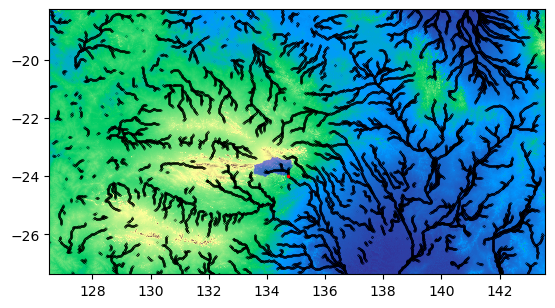

In [13]:
fig,ax = plt.subplots(1,1)
f = rio.open(filenm) #File containing DEM
Z=np.float64(np.squeeze(f.read()))
m,n = np.shape(Z)
lat = np.array([f.xy(i,0)[1] for i in range(m)])
lon = np.array([f.xy(0,i)[0] for i in range(n)])
plt.pcolormesh(lon,lat,Z,cmap='terrain')
athres = 10000 #threshold drainage area for plotting
IJ = np.where((A>athres) & (Z>=1))
plt.plot(lon[IJ[1]],lat[IJ[0]],'.k',markersize=.1)
plt.plot(pt[1],pt[0],'.r',markersize=3)
df.plot(ax=ax,color='blue',alpha=.5)



In [32]:
pts.iloc[100:103]

,OBSID1,OBSID2,STUDYID,geometry
100,S069WTS022,Novate,S069,POINT (9.45954 46.41203)
101,S069WTS023,Oglio,S069,POINT (10.34916 46.35119)
102,S069WTS024,Pfitsch,S069,POINT (11.47359 47.09398)


In [66]:
shps.iloc[101].geometry.bounds

(97.33914413779921, 39.49293985728793, 97.57081572040957, 39.87183086758495)

In [116]:
pts.iloc[615]

OBSID1                                        S095WTS006
OBSID2                                          QS-JG-43
STUDYID                                             S095
geometry    POINT (99.27335274048113 39.016331511204974)
Name: 615, dtype: object

x## Global

In [106]:
i=15
filenm = f'../data_earth_engine/nz_bas_hydroshed_{i}_.tif' #input file name for DEM
outnm = f'../data_earth_engine/nz_bas_hydroshed_{i}_output' #output for DEM
ptfile = './octo_points'
shpfile = '../Archive/crn_int_basins_071625'

if 0:
        pts = gpd.read_file(ptfile)
        pts=pts.to_crs('epsg:4326')
if 0:
        shps = gpd.read_file(shpfile)
        shps=shps.to_crs('epsg:4326')
xy =[pts.iloc[i].geometry.xy[0][0],pts.iloc[i].geometry.xy[1][0]]



In [113]:
pts.iloc[13:17]

,OBSID1,OBSID2,STUDYID,geometry
13,S076WTS001,Arr_2,S076,POINT (84.97039 27.96629)
14,S274WTS016,16PH005,S274,POINT (-145.73919 63.50637)
15,S082WTS015,Boo-M3,S082,POINT (-66.04359 -26.77025)
16,S086WTS004,NEP065,S086,POINT (84.42983 28.14677)


[547, 511]
500 500
(547, 511)
Boundary condition values have been reset
dx=26.7077215895671
Filling DEM
[547, 511]
547 511
(547, 511)
1074
-66.0435878636774
38.919734263299304


ValueError: zero-size array to reduction operation maximum which has no identity

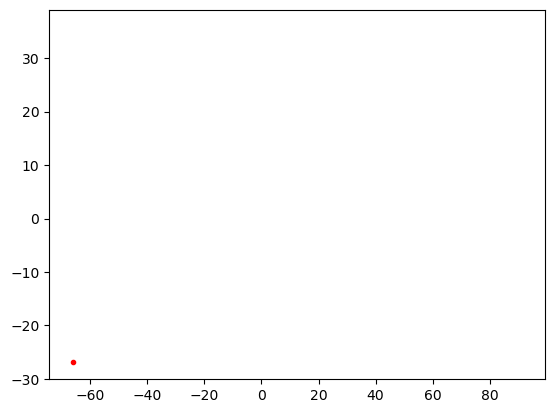

In [109]:
df,A=generate_pour_point_catchment(filenm, outnm, xy, target_area = 10, search_area =.01)

In [6]:
import jupydebug as jdb

In [95]:

frames2 = jdb.post_mortem()

In [96]:
acc = frames2[3].locals['acc']

In [97]:
w = frames2[3].locals['w']
y = frames2[3].locals['y']
x = y = frames2[3].locals['x']

In [98]:
acc[y-w:y+w+1,x-w:x+w+1]

np.shape(acc)

(747, 922)

In [110]:
xy

[-66.0435878636774, -26.770249953266188]

In [78]:
ny, nx = np.where(acc[y-w:y+w+1,x-w:x+w+1]>= np.max(acc[y-w:y+w+1,x-w:x+w+1])/1.25)

ValueError: zero-size array to reduction operation maximum which has no identity

In [12]:
frames2[3][

AttributeError: 'Frame' object has no attribute 'acc'

In [125]:
m,n = np.shape(Z)
x,y = np.meshgrid(np.arange(n),np.arange(m))

In [126]:
nans = np.isnan(Z.ravel())

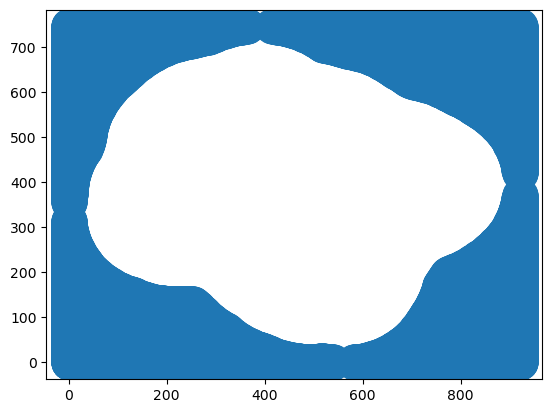

In [96]:
plt.plot(x.ravel()[nans],y.ravel()[nans],'.',markersize=50)